<a href="https://colab.research.google.com/github/antran28/Email-Classifier-Spam-or-Ham/blob/main/Email_Classifer_Spam_or_Ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reading dataset & Import libraries**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

!pip install scikit-plot
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Email message classification data.csv')

## **Overview of the dataset**

In [13]:
print("Test set size:", data.shape)

Test set size: (5572, 2)


In [14]:
data.count()
data = pd.DataFrame(data)

print(data)

     Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [16]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
data.tail()

,Category,Message
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [8]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [12]:
data.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


*Checking the number of spam and ham messages we have in our dataset*

In [21]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [31]:
pd.DataFrame(data['Category'].value_counts()).style.background_gradient()

,Category
ham,4825
spam,747


In [32]:
ham_percentage = (data['Category'].value_counts()[0] * 100) / data.shape[0]
spam_percentage = (data['Category'].value_counts()[1] * 100) / data.shape[0]

print(f'Percentage of ham data is: { round(ham_percentage, 2) }')
print(f'Percentage of spam data is: {round(spam_percentage, 2)}')

Percentage of ham data is: 86.59
Percentage of spam data is: 13.41


In [35]:
fig = px.pie(data, names = "Category",
             title = "<b>Counts in Category</b>",             
             color_discrete_sequence=px.colors.sequential.Blackbody_r,             
             hole = 0.5)

fig.update_layout(title_x = 0.5,
                  title_font = dict(size = 20))

fig.update_traces(textposition='inside',
                  textinfo='percent+label',    
                  textfont_size=15,                  
                  marker=dict(line=dict(color='#000000', width = 1.5)))


fig.show()

## **Check on missing value**

In [18]:
print(data.isnull().any()) 
print(data.dtypes)

Category    False
Message     False
dtype: bool
Category    object
Message     object
dtype: object


In [19]:
#find missing values in the dataset
#show only non-zero missing values
pd.isnull(data).sum()

Category    0
Message     0
dtype: int64

*There are no missing value in the dataset*

# **Feature Engineer**

*Create 2 new features in the dataset: Total Words and Total Chars, lets try to see how our target variable changes based on these features*

In [27]:
data['Total Words'] = data['Message'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["Message"].apply(count_total_words)

In [28]:
data.head()

,Category,Message,Total Words,Total Chars
0,ham,"Go until jurong point, crazy.. Available only ...",20,92
1,ham,Ok lar... Joking wif u oni...,6,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,128
3,ham,U dun say so early hor... U c already then say...,11,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,49


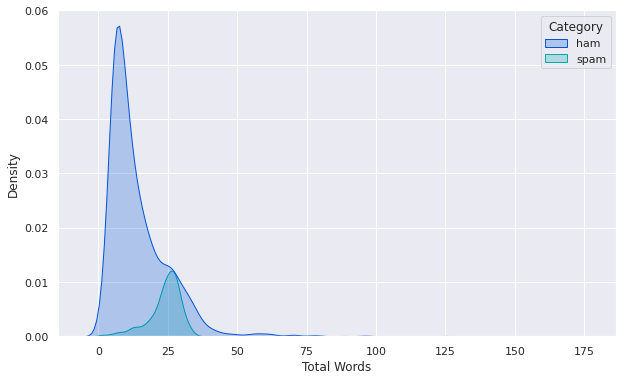

In [29]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

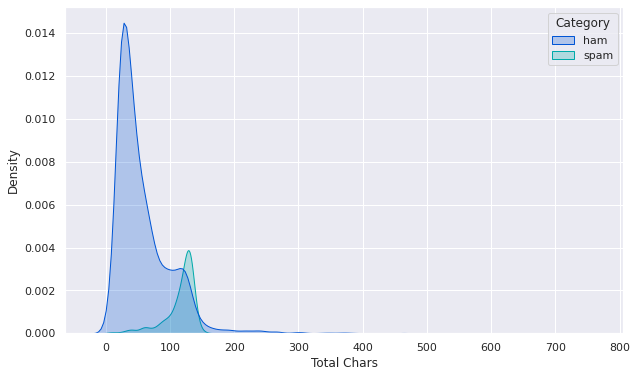

In [30]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

*We can see that there are more number of words in a text, so it is likely that those emails are spam*

# **Data cleaning and processing**

### **Remove URLS**

In [70]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['Message'] = data['Message'].apply(remove_url)

### **Lower case**

In [69]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['Message'] = data['Message'].apply(convert_lowercase)

### **Remove punctuations**

In [38]:
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['Message'] = data['Message'].apply(remove_punc)

### **Remove stopwords**

In [52]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [53]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['Message'] = data['Message'].apply(remove_stopwords)

### **Stemming**

In [81]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['Message'] = data['Message'].apply(perform_stemming)

In [82]:
data['Total Words After Transformation'] = data['Message'].apply(lambda x: np.log(len(x.split())))

### **Check data**

In [83]:
data.head()

,Category,Message,Total Words,Total Chars,Total Words After Transformation
0,1,go jurong point crazi avail bugi n great world...,20,92,2.772589
1,1,ok lar joke wif u oni,6,24,1.791759
2,0,free entri 2 wkli comp win fa cup final tkt 21...,28,128,3.135494
3,1,u dun say earli hor u c alreadi say,11,39,2.197225
4,1,nah dont think goe usf live around though,13,49,2.079442


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Category                          5572 non-null   int64  
 1   Message                           5572 non-null   object 
 2   Total Words                       5572 non-null   int64  
 3   Total Chars                       5572 non-null   int64  
 4   Total Words After Transformation  5572 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 217.8+ KB


In [87]:
Message = str('Message')

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Category                          5572 non-null   int64  
 1   Message                           5572 non-null   object 
 2   Total Words                       5572 non-null   int64  
 3   Total Chars                       5572 non-null   int64  
 4   Total Words After Transformation  5572 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 217.8+ KB


# **Data exploratory and visualization**

### **Most common words in Spam data**

In [57]:
data['Category'] = data['Category'].replace({'spam':0,'ham':1})

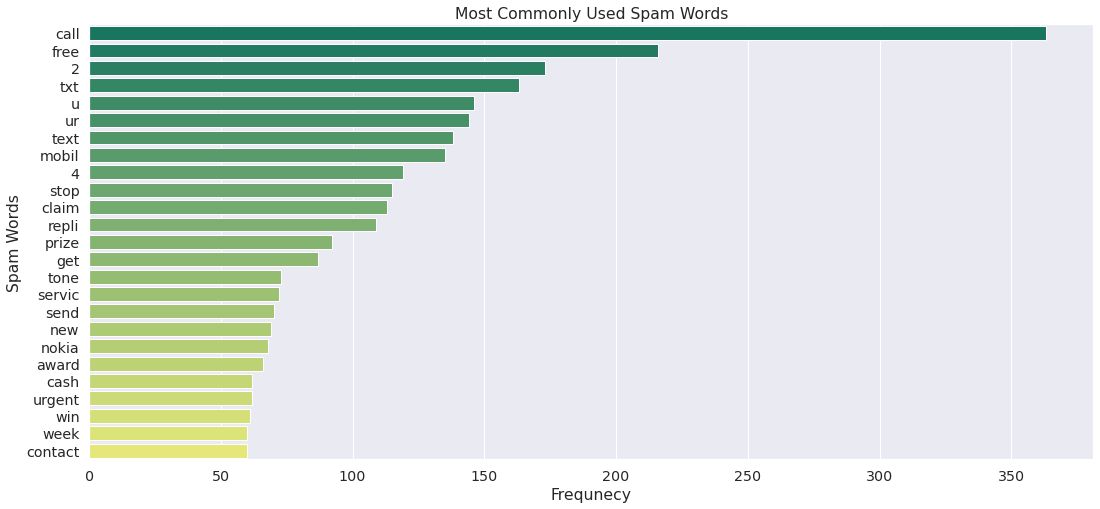

In [58]:
all_spam_words = []
for sentence in data[data['Category'] == 0]['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Spam Words")
plt.show()

### **Most common words in Ham data**

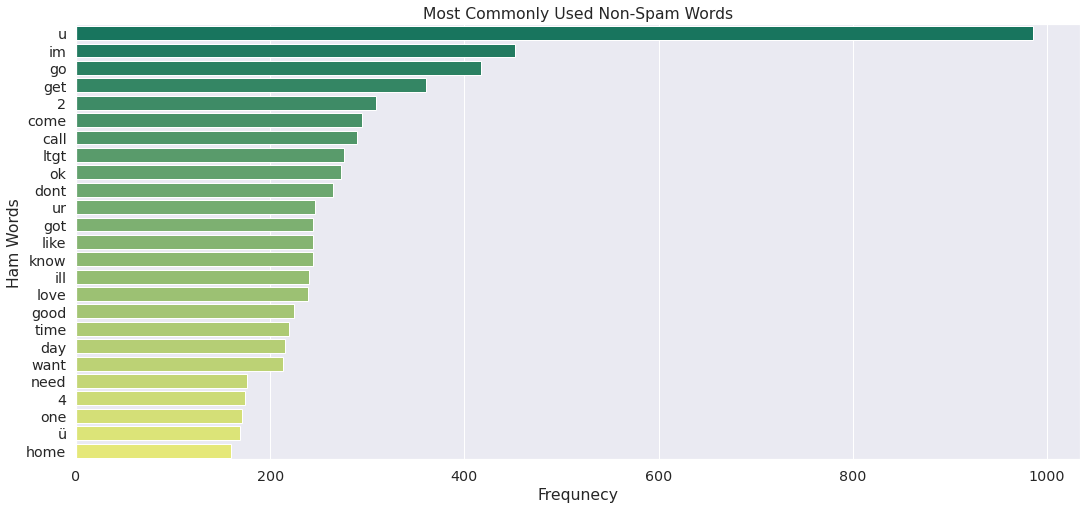

In [93]:
all_ham_words = []
for sentence in data[data['Category'] == 1]['Message'].to_list():
    for word in sentence.split():
        all_ham_words.append(word)

df = pd.DataFrame(Counter(all_ham_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Non-Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Ham Words")
plt.show()

# **Text classification**

### **Train model and test model**

In [96]:
X = data["Message"]
y = data['Category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [97]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

### **Naive Bayes Model**

### Multinomial Naive Bayes Classifier

In [98]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

Accuracy of the model: 0.968
Precision Score of the model: 0.967
Recall Score of the model: 0.997


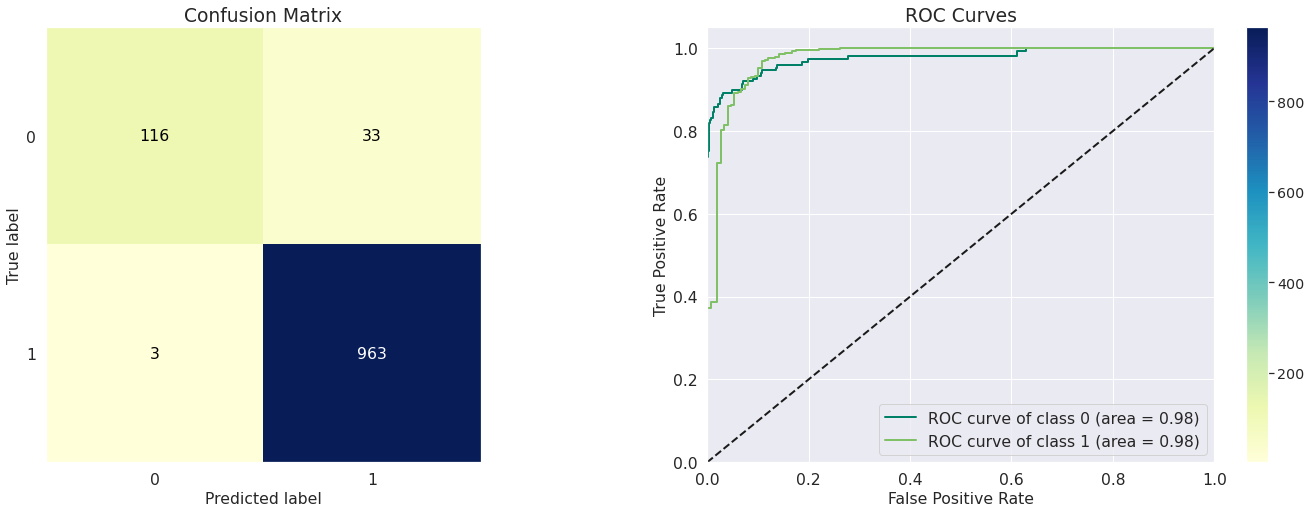

In [99]:
nb = MultinomialNB()
train_model(nb)

### Gaussian Naive Bayes Classifier

Accuracy of the model: 0.825
Precision Score of the model: 0.977
Recall Score of the model: 0.818


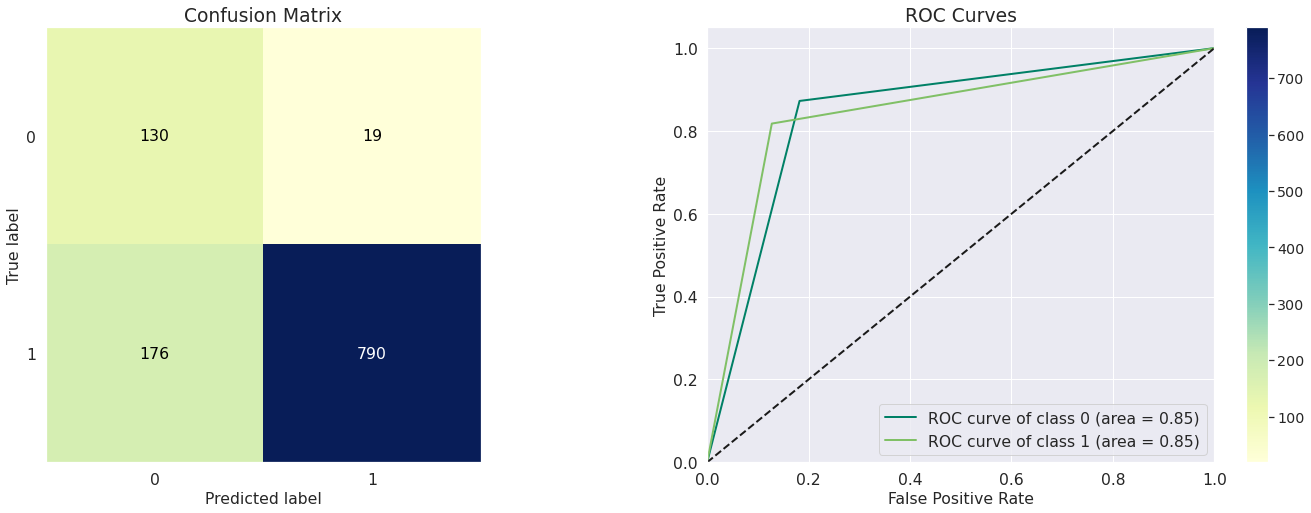

In [100]:
gb = GaussianNB()
train_model(gb)

***Result: The Multinomial Naive Bayes Classifier has higher accuracy level than Gaussian Naive Bayes Classifier***